In the previous demo, we looked at a few spatial and temporal discretizations of the nonlinear shallow water equations.
One of the challenging parts about solving systems of hyperbolic PDE like the shallow water equations is choosing a timestep that satisfies the Courant-Friedrichs-Lewy condition.
You can pick a good timestep ahead of time for a linear autonomous system.
A nonlinear system, on the other hand, might wander into weird parts of phase space where the characteristic wave speeds are much higher.
You might be able to pick a good timestep from the outset, but it's likely to be overly conservative and waste loads of compute time.
The tyranny of the CFL condition is the reason why it's such a common grumble among practitioners that ocean models explode if you look at them sideways.

All of the timestepping schemes we used in the previous demo were Runge-Kutta methods, which look something like this:

$$z_{n + 1} = z_n + \delta t\cdot \sum_ib_ik_i$$

where $b_i$ are weights and the stages $k_i$ are defined as

$$k_i = f\left(z_n + \delta t\sum_ja_{ij}k_j\right).$$

For the method to be explicit, we would need that $a_{ij} = 0$ if $j \ge i$.
You can find all the conditions for a Runge-Kutta method to have a certain order of accuracy in time in books like Hairer and Wanner.

Implicit Runge-Kutta schemes can eliminate many of the frustrating stability issues that occur with explicit schemes.
Implicit methods can use timesteps that far exceed the CFL-stable timestep.
But they introduce the added complexity of having to solve a nonlinear system at every timestep.
What globalization strategy will you use for Newton's method?
What preconditioner will you use in solving the associated linear systems?
These are all decisions you didn't have to make before.
It's possible to reduce some of the pain and suffering by using schemes for which $a_{ii}$ can be nonzero but $a_{ij} = 0$ if $j > 0$ -- these are the *diagonally-implicit* Runge-Kutta schemes.
Rather than have to solve a gigantic nonlinear system for all of the stages $k_i$ at once, you only have to solve a sequence of nonlinear systems for each stage.

The idea behind Rosenbrock methods is to **perform only a single iteration of Newton's method** for the nonlinear system defining the Runge-Kutta stages, rather than actually solve that system to convergence.
There are two heuristic justifications for Rosenbrock schemes.
First, a scheme like implicit Euler is only first-order accurate in time anyway, so there isn't much reason to do a really accurate nonlinear system solve as part of a fairly crude timestepping scheme.
Second, for a timestep that isn't too much larger than the characteristic timescale of the problem, the current system state is probably either in the quadratic convergence basin for Newton's method or at least fairly close.

More general Rosenbrock schemes follow from this idea.
The best reference I've found is one of the original papers on the subject, [Kaps and Rentrop (1979)](https://doi.org/10.1007/BF01396495).
This paper shows more general schemes in this family, derives the order conditions for the various weights and parameters, and perhaps most importantly derives an embedded Rosenbrock scheme that can be used for adaptive timestep control.
Here we'll show one of the most basic schemes, which comes from taking a single Newton step for the implicit midpoint rule.

### Setup

All of this is copied from the previous demo, so I'll give only cursory explanations.

In [1]:
import firedrake
from firedrake import Constant
g = Constant(9.81)
I = firedrake.Identity(2)

The following functions compute symbolic representations of the various shallow water fluxes.

In [2]:
from firedrake import inner, grad, dx
def cell_flux(z):
    Z = z.function_space()
    h, q = firedrake.split(z)
    ϕ, v = firedrake.TestFunctions(Z)
    
    f_h = -inner(q, grad(ϕ)) * dx

    F = outer(q, q) / h + 0.5 * g * h**2 * I
    f_q = -inner(F, grad(v)) * dx

    return f_h + f_q

In [3]:
from firedrake import avg, outer, dS
def central_facet_flux(z):
    Z = z.function_space()
    h, q = firedrake.split(z)
    ϕ, v = firedrake.TestFunctions(Z)
    
    mesh = z.ufl_domain()
    n = firedrake.FacetNormal(mesh)

    f_h = inner(avg(q), ϕ('+') * n('+') + ϕ('-') * n('-')) * dS

    F = outer(q, q) / h + 0.5 * g * h**2 * I
    f_q = inner(avg(F), outer(v('+'), n('+')) + outer(v('-'), n('-'))) * dS
    
    return f_h + f_q

In [4]:
from firedrake import sqrt, max_value
def lax_friedrichs_facet_flux(z):
    Z = z.function_space()
    h, q = firedrake.split(z)
    ϕ, v = firedrake.TestFunctions(Z)
    
    mesh = h.ufl_domain()
    n = firedrake.FacetNormal(mesh)
    
    c = abs(inner(q / h, n)) + sqrt(g * h)
    α = avg(c)
    
    f_h = -α * (h('+') - h('-')) * (ϕ('+') - ϕ('-')) * dS
    f_q = -α * inner(q('+') - q('-'), v('+') - v('-')) * dS

    return f_h + f_q

In [5]:
def topographic_forcing(z, b):
    Z = z.function_space()
    h = firedrake.split(z)[0]
    v = firedrake.TestFunctions(Z)[1]

    return -g * h * inner(grad(b), v) * dx

For an explicit time discretization and a DG method in space, we can use an ILU preconditioner with a block Jacobi inner preconditioner and this will exactly invert the DG mass matrix.

In [6]:
block_parameters = {
    'ksp_type': 'preonly',
    'pc_type': 'ilu',
    'sub_pc_type': 'bjacobi'
}

parameters = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'fieldsplit',
        'fieldsplit_0': block_parameters,
        'fieldsplit_1': block_parameters
    }
}

In [7]:
from firedrake import (
    NonlinearVariationalProblem as Problem,
    NonlinearVariationalSolver as Solver
)

class SSPRK3:
    def __init__(self, state, equation):
        z = state.copy(deepcopy=True)
        dt = firedrake.Constant(1.0)
        
        num_stages = 3
        zs = [state.copy(deepcopy=True) for stage in range(num_stages)]
        Fs = [equation(z), equation(zs[0]), equation(zs[1])]
        
        Z = z.function_space()
        w = firedrake.TestFunction(Z)
        forms = [
            inner(zs[0] - z, w) * dx - dt * Fs[0],
            inner(zs[1] - (3 * z + zs[0]) / 4, w) * dx - dt / 4 * Fs[1],
            inner(zs[2] - (z + 2 * zs[1]) / 3, w) * dx - 2 * dt / 3 * Fs[2]
        ]
        
        problems = [Problem(form, zk) for form, zk in zip(forms, zs)]
        solvers = [Solver(problem, **parameters) for problem in problems]
        
        self.state = z
        self.stages = zs
        self.timestep = dt
        self.solvers = solvers
    
    def step(self, timestep):
        self.timestep.assign(timestep)
        for solver in self.solvers:
            solver.solve()
        self.state.assign(self.stages[-1])

We'll create some auxiliary functions to actually run the simulation and create an animation of it.

In [8]:
from tqdm.notebook import trange

def run_simulation(solver, final_time, num_steps, output_freq):
    hs, qs = [], []
    qs = []
    pbar = trange(num_steps)
    for step in pbar:
        if step % output_freq == 0:
            h, q = solver.state.subfunctions
            hmin, hmax = h.dat.data_ro.min(), h.dat.data_ro.max()
            pbar.set_description(f'{hmin:5.3f}, {hmax:5.3f}')
            hs.append(h.copy(deepcopy=True))
            qs.append(q.copy(deepcopy=True))

        solver.step(timestep)
    
    return hs, qs

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def make_animation(hs, b, timestep, output_freq, **kwargs):
    fig, axes = plt.subplots()
    axes.set_aspect('equal')
    axes.set_xlim((0.0, Lx))
    axes.set_ylim((0.0, Ly))
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    η = firedrake.project(hs[0] + b, hs[0].function_space())
    colors = firedrake.tripcolor(
        hs[0], num_sample_points=1, axes=axes, **kwargs
    )
    
    def animate(h):
        η.project(h + b)
        colors.set_array(η.dat.data_ro[:])

    interval = 1e3 * output_freq * timestep
    animation = FuncAnimation(fig, animate, frames=hs, interval=interval)
    
    plt.close(fig)
    return HTML(animation.to_html5_video())

### Rosenbrock scheme

The implementation of the Rosenbrock scheme is fairly similar to the other timestepping methods we've shown before, but we have an extra term in the variational problem describing the linearization of the dynamics.
We're also making the initializer take some extra arguments for solver parameters.
When we were using explicit schemes, there was really only one sane choice of solver parameters because the matrix we had to invert was just a DG mass matrix.
Here, the choice of iterative solvers and preconditioners can become much more involved, as we'll show later.

In [10]:
from firedrake import derivative
class Rosenbrock:
    def __init__(self, state, equation, solver_parameters=None):
        z = state.copy(deepcopy=True)
        F = equation(z)
        
        z_n = z.copy(deepcopy=True)
        Z = z.function_space()
        w = firedrake.TestFunction(Z)

        dt = firedrake.Constant(1.0)

        dF = derivative(F, z, z_n - z)
        problem = Problem(
            inner(z_n - z, w) * dx - dt / 2 * dF - dt * F,
            z_n
        )
        solver = Solver(problem, solver_parameters=solver_parameters)

        self.state = z
        self.next_state = z_n
        self.timestep = dt
        self.solver = solver
        
    def step(self, timestep):
        self.timestep.assign(timestep)
        self.solver.solve()
        self.state.assign(self.next_state)

### Demonstration

We'll use the same input data and function spaces as before -- BDFM(2) for the momentum and DG(1) for the thickness.

In [11]:
nx, ny = 32, 32
Lx, Ly = 20., 20.
mesh = firedrake.PeriodicRectangleMesh(
    nx, ny, Lx, Ly, diagonal='crossed'
)

x = firedrake.SpatialCoordinate(mesh)
lx = 5.
y = Constant((lx, lx))
r = Constant(2.5)

h_0 = Constant(1.)
δh = Constant(1/16)
h_expr = h_0 + δh * max_value(0, 1 - inner(x - y, x - y) / r**2)

y = Constant((3 * lx, 3 * lx))
δb = Constant(1/4)
b = δb * max_value(0, 1 - inner(x - y, x - y) / r**2)

In [12]:
DG1 = firedrake.FunctionSpace(mesh, family='DG', degree=1)
BDFM2 = firedrake.FunctionSpace(mesh, family='BDFM', degree=2)
Z = DG1 * BDFM2

In [13]:
z0 = firedrake.Function(Z)
z0.sub(0).project(h_expr - b);

In [14]:
def F(z):
    return (
        cell_flux(z) +
        central_facet_flux(z) +
        lax_friedrichs_facet_flux(z) -
        topographic_forcing(z, b)
    )

##### SSPRK(3)

To get a baseline solution, we'll use the SSPRK(3) scheme from before.

In [15]:
solver = SSPRK3(z0, F)

In [16]:
final_time = 10.0
timestep = 5e-3
num_steps = int(final_time / timestep)
output_freq = 10
hs, qs = run_simulation(solver, final_time, num_steps, output_freq)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
make_animation(
    hs, b, timestep, output_freq, shading='gouraud', vmin=0.96, vmax=1.04
)

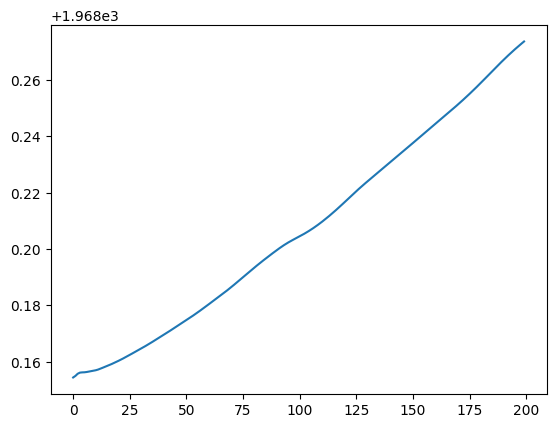

In [18]:
energies_ssprk3 = [
    firedrake.assemble(
        0.5 * (inner(q, q) / h + g * (h + b)**2) * dx
    )
    for h, q in zip(hs, qs)
]

fig, axes = plt.subplots()
axes.plot(energies_ssprk3);

So that we have a number to compare against for later, we can calculate the total energy drift from the beginning to the end of the simulation:

In [19]:
energies_ssprk3[-1] - energies_ssprk3[0]

np.float64(0.11940083238732768)

##### Rosenbrock

Now let's see how the new scheme scheme fares.

In [20]:
solver = Rosenbrock(z0, F)

We can use a much longer timestep than we could with explicit methods.

In [21]:
final_time = 10.0
timestep = 50e-3
num_steps = int(final_time / timestep)
output_freq = 1
hs, qs = run_simulation(solver, final_time, num_steps, output_freq)

  0%|          | 0/200 [00:00<?, ?it/s]

A subtle but interesting feature you can see in this animation is that the spurious wave emanating from the bump at the bed has a much smaller magnitude with the Rosenbrock scheme than with any of the explicit schemes.

In [22]:
make_animation(
    hs, b, timestep, output_freq, shading='gouraud', vmin=0.96, vmax=1.04
)

The energy drift is cut by a factor of 5 compared to using an explicit scheme.
On top of that, we were able to achieve it using much larger timesteps than were CFL-stable before, and as a consequence the overall time for the simulation is shorter.

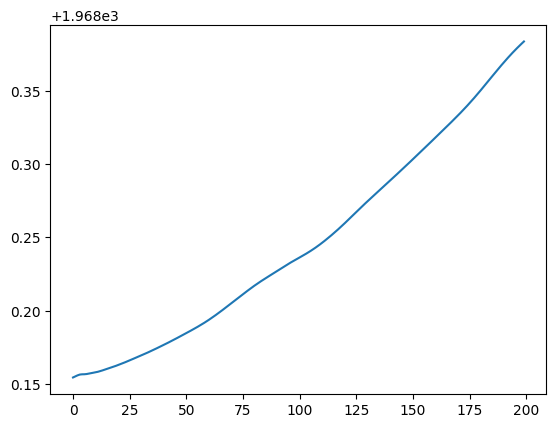

In [23]:
energies_rosenbrock = [
    firedrake.assemble(
        0.5 * (inner(q, q) / h + g * (h + b)**2) * dx
    )
    for h, q in zip(hs, qs)
]

fig, axes = plt.subplots()
axes.plot(energies_rosenbrock);

In [24]:
energies_rosenbrock[-1] - energies_rosenbrock[0]

np.float64(0.22949445795711654)

**FIXME**: the statement above was from the last time I updated this in ~2022.
The results from SSPRK3 got better and from Rosenbrock worse on a more recent Firedrake install.
I should probably investigate this and figure out what's different.

### Conclusion

In the previous post, we showed some of the difficulties associated with solving the shallow water equations.
The two biggest problems we ran into were getting a CFL-stable timestep and controlling energy drift.
Rosenbrock schemes almost eliminate stability problems and decimate the drift as well.
While they are substantially more expensive for a single timestep, there are a lot of gains to be had by using a better preconditioner.
On top of that, we can gain other efficiencies by approximating the linearized dynamics with a matrix that's easier to invert.